In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap

import anndata
import scanpy as sc

from sklearn.neighbors import kneighbors_graph
from cobolt.model import Cobolt

/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
adata = anndata.read("../Data/adata_raw.h5ad.gz")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [ ]:
adata

In [ ]:
from cobolt.utils import MultiomicDataset,SingleData
from scipy import sparse


def depair_anndata(adata, n_unpaired):
    modality_switch = np.where(adata.var.modality == "Peaks")[0].min()
    
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    unpaired_idx = indices[:n_unpaired]
    paired_idx = indices[n_unpaired:]
    
    adata_p = adata[paired_idx].copy()
    adata_np_acc = adata[unpaired_idx].copy()
    adata_np_exp = adata_np_acc.copy()
    adata_p.obs['dataset']='p'

    adata_np_acc.X[:, :modality_switch] = 0
    adata_np_exp.X[:, modality_switch:] = 0
    
    adata_np_acc1 = adata_np_acc[:,adata.var.modality == "Peaks"].copy()
    adata_np_exp1 = adata_np_exp[:,adata.var.modality == 'Gene Expression'].copy()
    adata_p_acc = adata_p[:,adata.var.modality == "Peaks"].copy()
    adata_p_exp = adata_p[:,adata.var.modality == "Gene Expression"].copy()

    adata_np_exp1.obs['dataset']='np_exp'
    adata_np_acc1.obs['dataset']='np_acc'
    adata_np_exp.obs['dataset']='np_exp'
    adata_np_acc.obs['dataset']='np_acc'

    rna_np_sd = SingleData(
    feature_name="RNA",
    dataset_name="np_exp",
    feature=adata_np_exp1.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_np_exp1.X),
    barcode=adata_np_exp1.obs.barcodes.to_numpy()
)
    atac_np_sd = SingleData(
    feature_name="ATAC",
    dataset_name="np_acc",
    feature=adata_np_acc1.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_np_acc1.X),
    barcode=adata_np_acc1.obs.barcodes.to_numpy()
)

    rna_paired = SingleData(
    feature_name="RNA",
    dataset_name="p",
    feature=adata_p_exp.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_p_exp.X),
    barcode=adata_p_exp.obs.barcodes.to_numpy()
)

    atac_paired = SingleData(
    feature_name="ATAC",
    dataset_name="p",
    feature=adata_p_acc.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_p_acc.X),
    barcode=adata_p_acc.obs.barcodes.to_numpy()
)
    multi_dt = MultiomicDataset.from_singledata(rna_np_sd, atac_np_sd, rna_paired, atac_paired)
    print(multi_dt)
    
    adata = anndata.AnnData(
        scipy.sparse.vstack((adata_p.X, adata_np_acc.X, adata_np_exp.X)),
        obs=pd.concat((adata_p.obs, adata_np_acc.obs, adata_np_exp.obs)),
        var=adata_p.var
    )
    adata.X.eliminate_zeros()
    
    has_chr = np.asarray(adata.X[:, modality_switch:].sum(axis=1) > 0).squeeze()
    has_rna = np.asarray(adata.X[:, :modality_switch].sum(axis=1) > 0).squeeze()
    adata.obs["modality"] = "expression"
    adata.obs.modality.loc[has_chr] = "accessibility"
    adata.obs.modality.loc[np.logical_and(has_chr, has_rna)] = "paired"
    return adata.copy(), multi_dt

def corrupt_and_process(adata, unpaired_rate):
    if os.path.exists("../Data/cobolt_corruption/adata_r{}.h5ad.gz".format(int(unpaired_rate * 100))):
        print("already done, skipping!")
        return
    print("corrupting AnnData...")
    adata,multi_dt = depair_anndata(adata, int(unpaired_rate * adata.shape[0]))
    loc=[]
    for x in adata:
        loc.append(x.obs.dataset + '~' + x.obs.barcodes)
    loc=np.array(loc).reshape(-1)
    print("training model...")
    model = Cobolt(dataset=multi_dt, lr=0.0001, n_latent=128)
    model.train(num_epochs=400)
    model.calc_all_latent()
    model.save_model("../model_trained/cobolt/pbmc_r{}.pth".format(int(unpaired_rate * 100)))
    latent = model.get_all_latent()[0]
    latent_df = pd.DataFrame(latent, index=multi_dt.get_barcode())
# 重排 latent，确保和你下游用的 AnnData 匹配
    latent_df = latent_df.loc[loc]
# 安全赋值
    adata.obsm["X_multiVI"] = latent_df.values
#adata.obsm["X_multiVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_multiVI")
    sc.tl.umap(adata, min_dist=0.2)
    adata.write("../Data/cobolt_corruption/adata_r{}.h5ad.gz".format(int(unpaired_rate * 100)), compression='gzip')

In [ ]:
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
for npp in NPPs:
    print(npp)
    corrupt_and_process(adata, npp)

0.0


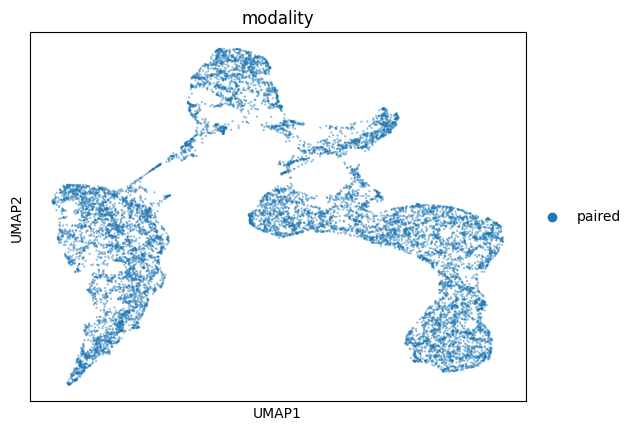

0.01


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


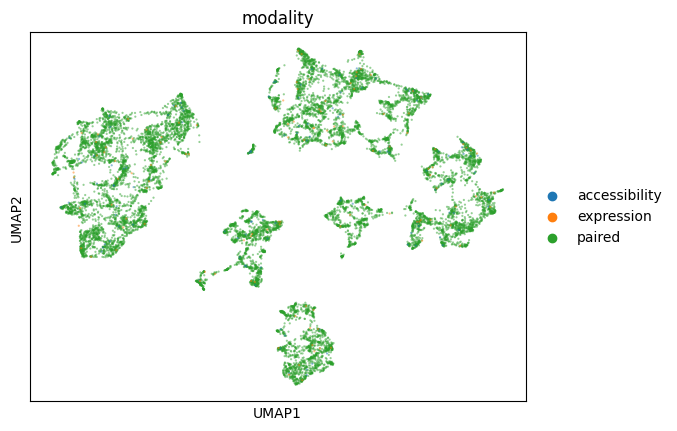

/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


0.1


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


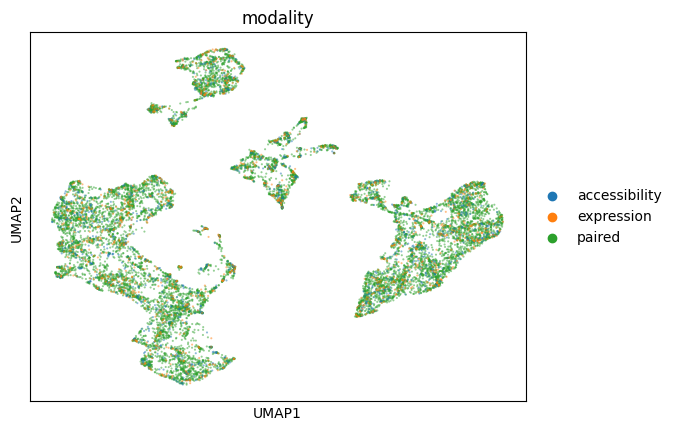

/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


0.25


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


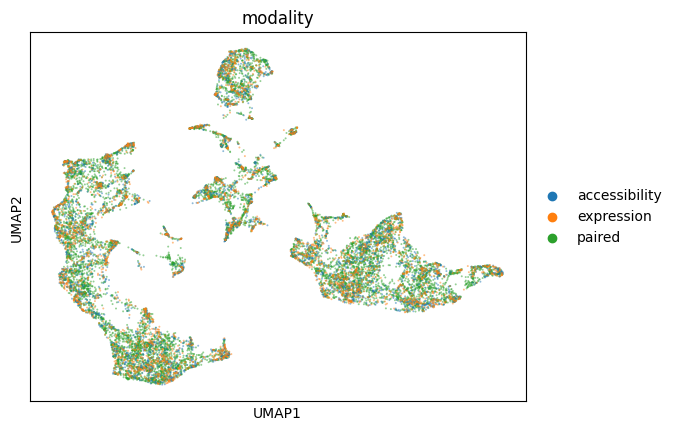

/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


0.5


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


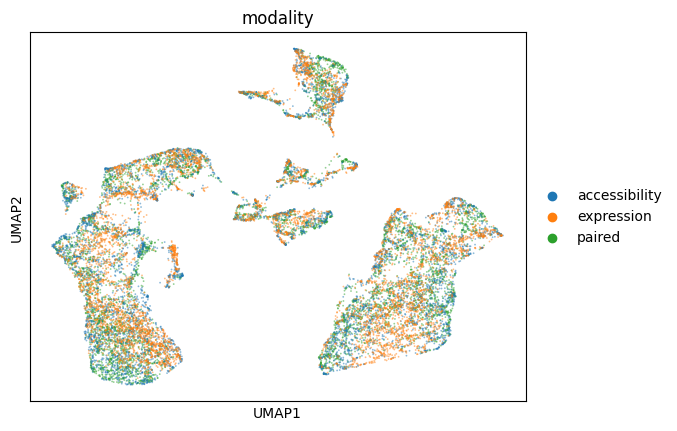

/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


0.75


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


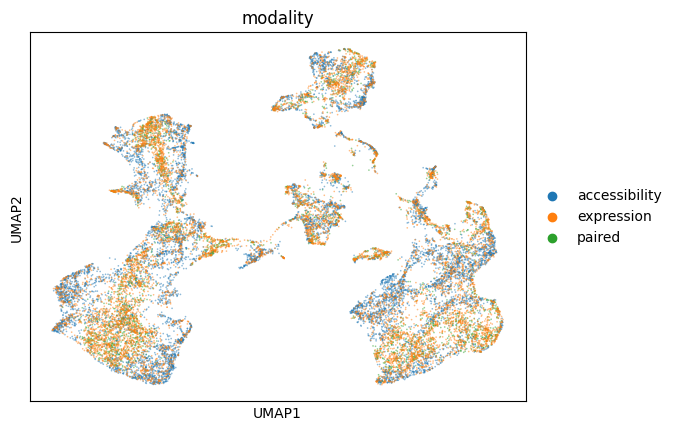

0.9


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


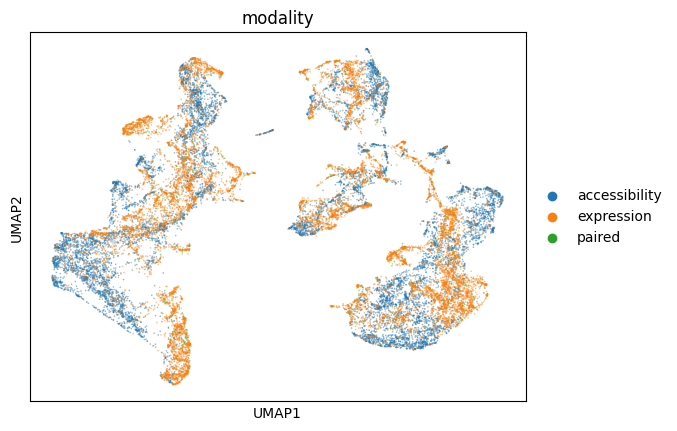

0.99


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


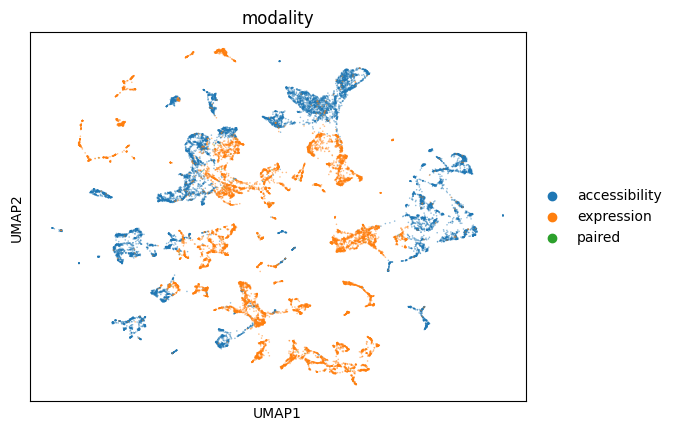

In [4]:
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
for npp in NPPs:
    print(npp)
    adata = anndata.read("../Data/cobolt_corruption/adata_r{}.h5ad.gz".format(int(npp * 100)))
    sc.pl.umap(adata, color='modality', alpha=0.5)

In [3]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [4]:
from scipy.spatial.distance import cdist
def compute_foscttm(latent_acc, latent_exp):
    """
    计算 FOSCTTM 分数
    
    返回: 平均 FOSCTTM 值
    """
    distances = cdist(latent_acc, latent_exp, metric='euclidean')  # 计算所有细胞的欧式距离
    foscttm_values = []
    num_cells=latent_exp.shape[0]

    for i in range(num_cells):  # 遍历所有已知匹配的细胞对
        d_true = distances[i, i]  # 真实匹配的距离
        d_others = distances[i, :]  # 该细胞到所有其他细胞的距离
        
        rank = np.sum(d_others < d_true) / num_cells  # 计算 FOSCTTM
        foscttm_values.append(rank)

    return np.mean(foscttm_values)  # 返回平均 FOSCTTM 值

In [5]:
from sklearn.metrics import silhouette_score
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
distances = []
enrichments = []
foscttms=[]
asw_modality=[]
for npp in NPPs[1:]:
    print(npp)
    adata = anndata.read_h5ad("../Data/cobolt_corruption/adata_r{}.h5ad.gz".format(int(npp * 100)))
    latent = adata.obsm['X_multiVI']
    for K in [15,50,150,500]:
        print(K)
        enrichments.append((
            npp, 
            K, 
            compute_batch_mixing(latent, adata.obs.modality, K),
        ))
    latent_exp = latent[adata.obs.modality == 'expression']
    latent_acc = latent[adata.obs.modality == 'accessibility']
    distances.append(pd.DataFrame({
        'rate':npp,
        'distances':(((latent_exp - latent_acc) ** 2).sum(axis=1) ** 0.5),
    }))
    foscttms.append((npp,compute_foscttm(latent_acc,latent_exp)))
    asw_modality.append((npp,silhouette_score(latent, adata.obs["modality"], metric='euclidean')))

0.01


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.1


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.25


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.5


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.75


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.9


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.99


/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500


<Axes: xlabel='rate', ylabel='enrichment'>

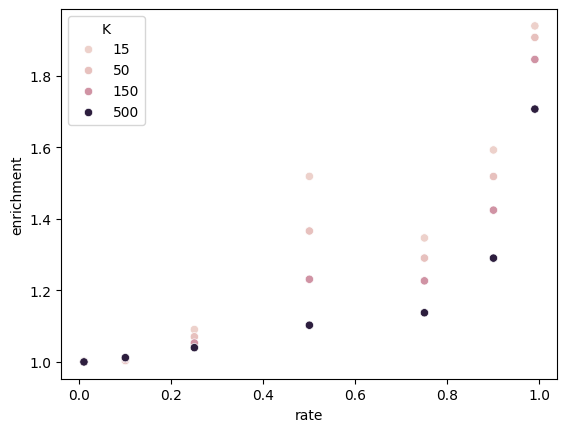

In [6]:
df_enrich = pd.DataFrame(enrichments, columns=('rate', 'K', 'enrichment'))
sns.scatterplot(data=df_enrich, x='rate', y='enrichment', hue='K')

In [12]:
print([float(x[2]) for x in enrichments if x[1] == 500])

[1.0004921758641367, 1.0124029514308077, 1.0403496503496503, 1.1030023310023311, 1.1378091031775244, 1.2904382748982464, 1.706653477700786]


In [13]:
dist_mean = [distances[0].distances.mean(), distances[1].distances.mean(), distances[2].distances.mean(), distances[3].distances.mean(), 
             distances[4].distances.mean(), distances[5].distances.mean(), distances[6].distances.mean()]
dist_mean

[np.float32(12.24396),
 np.float32(12.04545),
 np.float32(10.981727),
 np.float32(10.807638),
 np.float32(7.4589777),
 np.float32(5.471498),
 np.float32(6.803792)]

In [9]:
foscttms

[(0.01, np.float64(0.5279166666666666)),
 (0.1, np.float64(0.5061304034037691)),
 (0.25, np.float64(0.5045288821512598)),
 (0.5, np.float64(0.5045211753503462)),
 (0.75, np.float64(0.22420573469524518)),
 (0.9, np.float64(0.15336991393688476)),
 (0.99, np.float64(0.16990360560786066))]

In [10]:
asw_modality

[(0.01, np.float32(-0.01426668)),
 (0.1, np.float32(0.0049984218)),
 (0.25, np.float32(0.0033660715)),
 (0.5, np.float32(-0.008366537)),
 (0.75, np.float32(-0.010791562)),
 (0.9, np.float32(-0.0075466847)),
 (0.99, np.float32(0.0024851433))]

<Axes: xlabel='rate', ylabel='distances'>

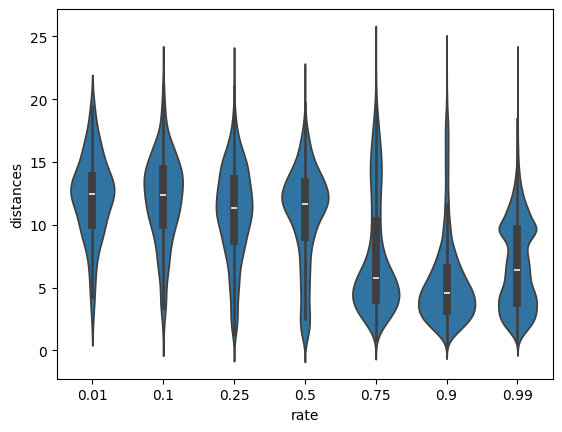

In [8]:
dist_df = pd.concat(distances)
sns.violinplot(data=dist_df, x='rate', y='distances')